In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import random
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, f1_score

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:
# import os
# import shutil

# def mover_imagens_para_pasta_raiz(dataset_path):
#     for classe in os.listdir(dataset_path):
#         classe_path = os.path.join(dataset_path, classe)

#         # Pular se não for pasta
#         if not os.path.isdir(classe_path):
#             continue

#         for raiz, subdirs, arquivos in os.walk(classe_path):
#             for arquivo in arquivos:
#                 if arquivo.lower().endswith(('.jpg', '.jpeg', '.png')):
#                     origem = os.path.join(raiz, arquivo)
#                     destino = os.path.join(classe_path, arquivo)

#                     # Evitar sobrescrever se nome repetir
#                     base, ext = os.path.splitext(arquivo)
#                     contador = 1
#                     while os.path.exists(destino):
#                         destino = os.path.join(classe_path, f"{base}_{contador}{ext}")
#                         contador += 1

#                     shutil.copy2(origem, destino)

#     print("✅ Imagens copiadas para o nível da classe com sucesso!")

# # Use o caminho onde estão as classes
# mover_imagens_para_pasta_raiz("siris_dataset")


**Separando dataset**

In [4]:
import os
import shutil
import random
import cv2 as cv
# Caminhos
original_dataset = "siris_dataset"
destino_base = "siris_dataset_split"
train_path = os.path.join(destino_base, "train")
test_path = os.path.join(destino_base, "test")
external_path = os.path.join(destino_base, "external")
split_train = 0.7
split_test = 0.2
split_external = 0.1  # 10% para avaliação final


# Extensões permitidas
extensoes_validas = (".jpg", ".jpeg", ".png", ".bmp")

# Cria diretórios de saída
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)
os.makedirs(external_path, exist_ok=True)

# Para cada classe no dataset
for classe in os.listdir(original_dataset):
    classe_path = os.path.join(original_dataset, classe)
    if not os.path.isdir(classe_path):
        continue

    imagens = [f for f in os.listdir(classe_path) if f.lower().endswith(extensoes_validas)]
    random.shuffle(imagens)

    total = len(imagens)
    train_end = int(total * split_train)
    test_end = train_end + int(total * split_test)

    imagens_train = imagens[:train_end]
    imagens_test = imagens[train_end:test_end]
    imagens_external = imagens[test_end:]

    # Criar diretórios de saída por classe
    os.makedirs(os.path.join(train_path, classe), exist_ok=True)
    os.makedirs(os.path.join(test_path, classe), exist_ok=True)
    os.makedirs(os.path.join(external_path, classe), exist_ok=True)

    # Copiar imagens de treino
    for img in imagens_train:
        img_gray = cv.imread(os.path.join(classe_path, img))
        img_gray = cv.cvtColor(img_gray, cv.COLOR_BGR2GRAY)
        src = os.path.join(classe_path, img)
        dst = os.path.join(train_path, classe, img)
        try:
            cv.imwrite(os.path.join(train_path, classe, img), img_gray)
        except Exception as e:
            print(f"Erro ao copiar {src}: {e}")

    # Copiar imagens de teste
    for img in imagens_test:
        img_gray = cv.imread(os.path.join(classe_path, img))
        img_gray = cv.cvtColor(img_gray, cv.COLOR_BGR2GRAY)
        src = os.path.join(classe_path, img)
        try:
            cv.imwrite(os.path.join(test_path, classe, img), img_gray)
        except Exception as e:
            print(f"Erro ao copiar {src}: {e}")

    # Copiar imagens externas
    for img in imagens_external:
        img_gray = cv.imread(os.path.join(classe_path, img))
        img_gray = cv.cvtColor(img_gray, cv.COLOR_BGR2GRAY)
        src = os.path.join(classe_path, img)
        try:
            cv.imwrite(os.path.join(external_path, classe, img), img_gray)
        except Exception as e:
            print(f"Erro ao copiar {src}: {e}")

print("✅ Imagens divididas em treino, teste e conjunto externo com sucesso!")


✅ Imagens divididas em treino, teste e conjunto externo com sucesso!


**Treinamento do modelo ResNet18**

In [ ]:
train_losses = []
test_accuracies = []

# =======================
# 1. CONFIGURAÇÕES
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
num_epochs = 10
data_dir = "siris_dataset_split"  # Caminho para dataset com train/ e test/

# =======================
# 2. TRANSFORMAÇÕES
# =======================
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Todas as redes esperam 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Padrão ImageNet
                         std=[0.229, 0.224, 0.225])
])

# =======================
# 3. DATALOADERS
# =======================
generator = torch.Generator().manual_seed(SEED)
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=generator)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes

# =======================
# 4. MODELO (troque aqui)
# =======================
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Para ResNet18

model = model.to(device)

# =======================
# 5. LOSS E OTIMIZADOR
# =======================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# =======================
# 6. TREINAMENTO
# =======================
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Época {epoch+1}, Loss: {running_loss / len(train_loader)}")

    train_losses.append(running_loss / len(train_loader))

# =======================
# 7. AVALIAÇÃO NO TESTE
# =======================
model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Armazena previsões e rótulos verdadeiros
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Acurácia final
        acc = 100 * correct / total
        test_accuracies.append(acc)
    print(f"✅ Acurácia no teste após época {epoch+1}: {acc:.2f}%")

# === Relatório e Matriz de Confusão ===
print(f"\n📊 Acurácia final: {accuracy_score(all_labels, all_preds)*100:.2f}%")
print(f"🎯 F1-score macro: {f1_score(all_labels, all_preds, average='macro'):.2f}")
print(f"🎯 F1-score weighted: {f1_score(all_labels, all_preds, average='weighted'):.2f}")

print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=class_names))

# One-hot encoding dos rótulos verdadeiros
y_true = label_binarize(all_labels, classes=list(range(num_classes)))
y_score = np.array(all_probs)

# Plotar curva ROC para cada classe
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curvas ROC por Classe')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

c:\Users\vitin\Documents\LABEEC\siri\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vitin\Documents\LABEEC\siri\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Época 1, Loss: 0.8670396407445272
Época 2, Loss: 0.15911893546581268
Época 3, Loss: 0.05169183034449816
Época 4, Loss: 0.03894476521139344
Época 5, Loss: 0.06308733653277158
Época 6, Loss: 0.04869929300621152
Época 7, Loss: 0.031198086868971586
Época 8, Loss: 0.028878680476918817
Época 9, Loss: 0.019262246050251026
Época 10, Loss: 0.027844933878319957
✅ Acurácia no teste após época 10: 94.34%

📊 Acurácia final: 94.34%
🎯 F1-score macro: 0.94
🎯 F1-score weighted: 0.94

=== Classification Report ===
                  precision    recall  f1-score   support

    C. bocourti1       0.97      1.00      0.98        58
       C. danae1       0.88      0.95      0.92        63
C. exasperatus10       0.95      0.87      0.91        23
   C. larvatus01       1.00      1.00      1.00        34
     C. ornatus1       0.94      0.87      0.91        55
     C. sapidus0       0.97      0.94      0.95        32

        accuracy                           0.94       265
       macro avg       0.95     

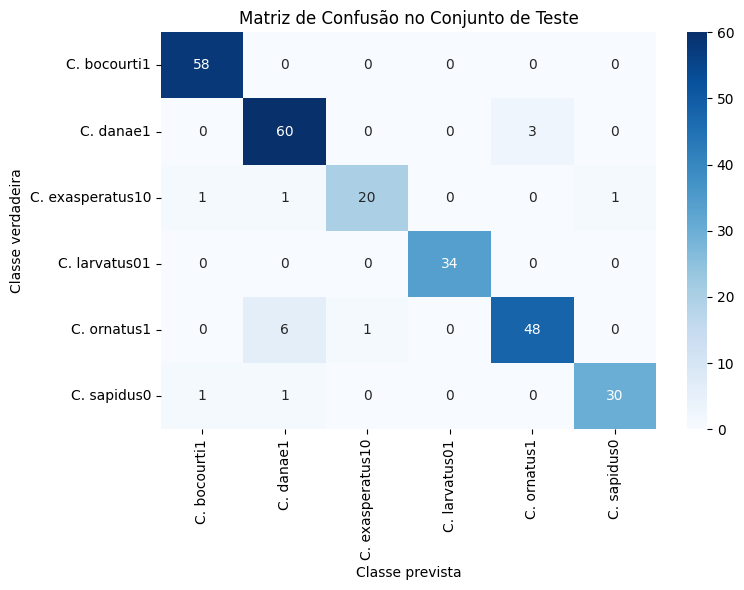

In [6]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Classe prevista")
plt.ylabel("Classe verdadeira")
plt.title("Matriz de Confusão no Conjunto de Teste")
plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), './models_gray/modelo_final_res_net.pth')

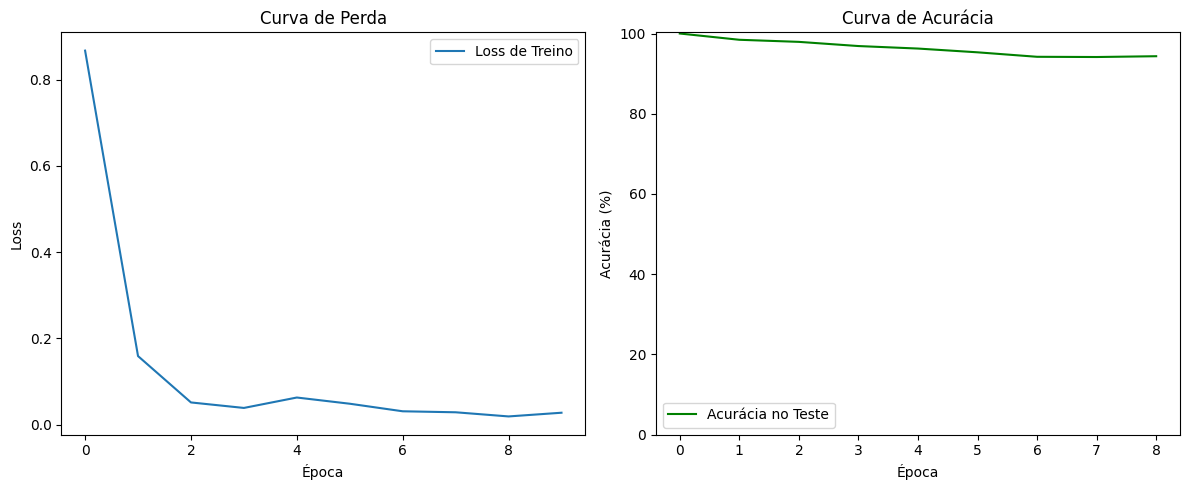

In [8]:
# Plotar curva de perda
plt.figure(figsize=(12, 5))
# plt.title("Evolução da Perda e Acurácia Durante o Treinamento")

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss de Treino')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Perda')
plt.legend()

# Plotar curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Acurácia no Teste', color='green')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.title('Curva de Acurácia')
plt.legend()
plt.ylim(bottom=0)  

plt.tight_layout()
plt.show()


**AlexNet Treinamento**

c:\Users\vitin\Documents\LABEEC\siri\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vitin\Documents\LABEEC\siri\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Época 1, Loss: 1.0881989101568859
Época 2, Loss: 0.5112732554475466
Época 3, Loss: 0.24913768110175927
Época 4, Loss: 0.156528609773765
Época 5, Loss: 0.09725984937200943
Época 6, Loss: 0.08504721991096933
Época 7, Loss: 0.03392493337451015
Época 8, Loss: 0.030723032987831782
Época 9, Loss: 0.029184483063484853
Época 10, Loss: 0.04248757956083864
✅ Acurácia no teste após época 10: 91.32%

📊 Acurácia final: 91.32%
🎯 F1-score macro: 0.90
🎯 F1-score weighted: 0.91

=== Classification Report ===
                  precision    recall  f1-score   support

    C. bocourti1       0.97      0.97      0.97        58
       C. danae1       0.82      0.97      0.89        63
C. exasperatus10       0.94      0.65      0.77        23
   C. larvatus01       0.97      0.97      0.97        34
     C. ornatus1       0.96      0.85      0.90        55
     C. sapidus0       0.88      0.94      0.91        32

        accuracy                           0.91       265
       macro avg       0.92      0.89

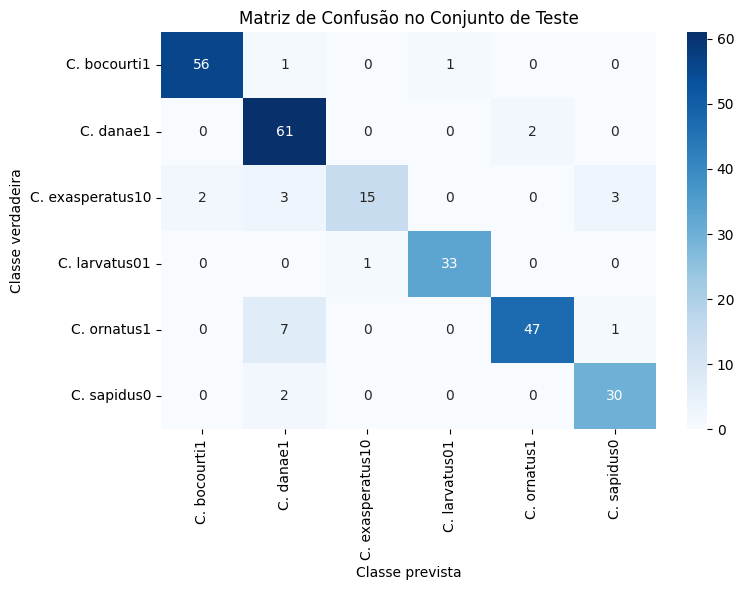

In [ ]:

train_losses = []
test_accuracies = []

# =======================
# 1. CONFIGURAÇÕES
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
num_epochs = 10
data_dir = "siris_dataset_split"  # Caminho para dataset com train/ e test/

# =======================
# 2. TRANSFORMAÇÕES
# =======================
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Todas as redes esperam 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Padrão ImageNet
                         std=[0.229, 0.224, 0.225])
])

# =======================
# 3. DATALOADERS
# =======================
generator = torch.Generator().manual_seed(SEED)
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generator)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, generator=generator)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes

# =======================
# 4. MODELO
# =======================

model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

model = model.to(device)

# =======================
# 5. LOSS E OTIMIZADOR
# =======================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# =======================
# 6. TREINAMENTO
# =======================
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Época {epoch+1}, Loss: {running_loss / len(train_loader)}")

    train_losses.append(running_loss / len(train_loader))

# =======================
# 7. AVALIAÇÃO NO TESTE
# =======================
model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Armazena previsões e rótulos verdadeiros
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Acurácia final
        acc = 100 * correct / total
        test_accuracies.append(acc)
    print(f"✅ Acurácia no teste após época {epoch+1}: {acc:.2f}%")

# === Relatório e Matriz de Confusão ===

print(f"\n📊 Acurácia final: {accuracy_score(all_labels, all_preds)*100:.2f}%")
print(f"🎯 F1-score macro: {f1_score(all_labels, all_preds, average='macro'):.2f}")
print(f"🎯 F1-score weighted: {f1_score(all_labels, all_preds, average='weighted'):.2f}")

print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Classe prevista")
plt.ylabel("Classe verdadeira")
plt.title("Matriz de Confusão no Conjunto de Teste")
plt.tight_layout()
plt.show()


# One-hot encoding dos rótulos verdadeiros
y_true = label_binarize(all_labels, classes=list(range(num_classes)))
y_score = np.array(all_probs)

# Plotar curva ROC para cada classe
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curvas ROC por Classe')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), './models_gray/modelo_final_alex_net.pth')

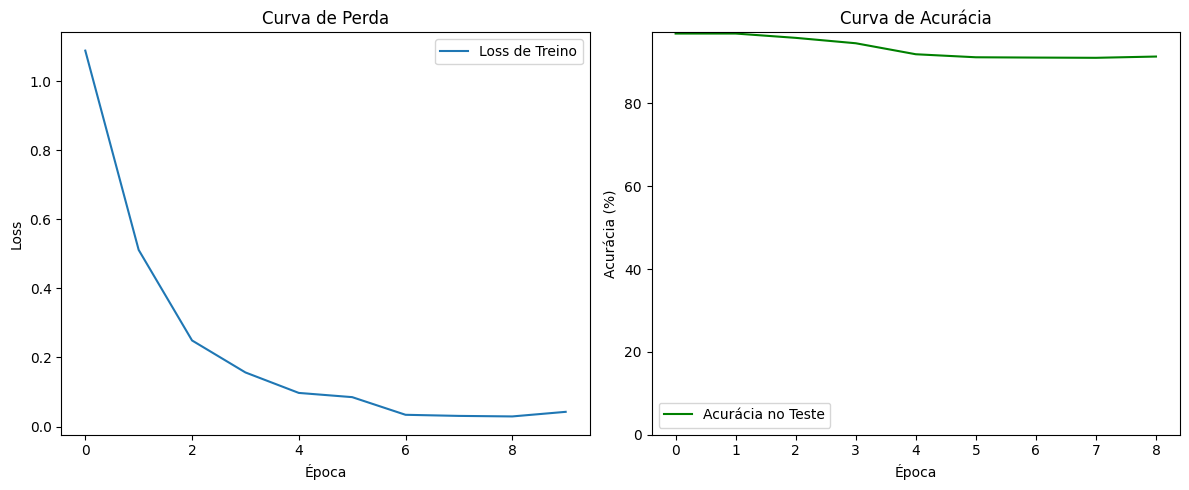

In [11]:
# Plotar curva de perda
plt.figure(figsize=(12, 5))
# plt.title("Evolução da Perda e Acurácia Durante o Treinamento")

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss de Treino')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Perda')
plt.legend()

# Plotar curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Acurácia no Teste', color='green')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.title('Curva de Acurácia')
plt.legend()
plt.ylim(bottom=0)  

plt.tight_layout()
plt.show()

**MobileNetV2 Treinamento**

c:\Users\vitin\Documents\LABEEC\siri\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vitin\Documents\LABEEC\siri\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Época 1, Loss: 1.0447706540425619
Época 2, Loss: 0.3419387757778168
Época 3, Loss: 0.16723648185531298
Época 4, Loss: 0.06556786006937425
Época 5, Loss: 0.06545100891962648
Época 6, Loss: 0.03728357786312699
Época 7, Loss: 0.02186536641481022
Época 8, Loss: 0.013251725723966956
Época 9, Loss: 0.020682721096090973
Época 10, Loss: 0.027087755578880508
✅ Acurácia no teste após época 10: 95.09%

📊 Acurácia final: 95.09%
🎯 F1-score macro: 0.95
🎯 F1-score weighted: 0.95

=== Classification Report ===
                  precision    recall  f1-score   support

    C. bocourti1       0.98      1.00      0.99        58
       C. danae1       0.90      0.97      0.93        63
C. exasperatus10       0.95      0.78      0.86        23
   C. larvatus01       1.00      1.00      1.00        34
     C. ornatus1       0.96      0.89      0.92        55
     C. sapidus0       0.94      1.00      0.97        32

        accuracy                           0.95       265
       macro avg       0.95      0

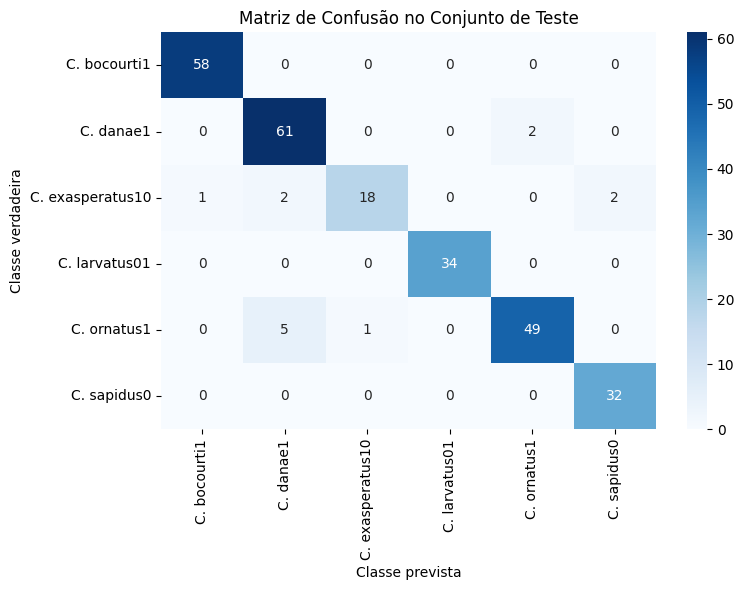

In [ ]:

train_losses = []
test_accuracies = []

# =======================
# 1. CONFIGURAÇÕES
# =======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
num_epochs = 10
data_dir = "siris_dataset_split"  # Caminho para dataset com train/ e test/

# =======================
# 2. TRANSFORMAÇÕES
# =======================
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Todas as redes esperam 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Padrão ImageNet
                         std=[0.229, 0.224, 0.225])
])

# =======================
# 3. DATALOADERS
# =======================
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_classes = len(train_dataset.classes)

# =======================
# 4. MODELO
# =======================

model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

model = model.to(device)

# =======================
# 5. LOSS E OTIMIZADOR
# =======================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# =======================
# 6. TREINAMENTO
# =======================
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Época {epoch+1}, Loss: {running_loss / len(train_loader)}")

    train_losses.append(running_loss / len(train_loader))

# =======================
# 7. AVALIAÇÃO NO TESTE
# =======================
model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Armazena previsões e rótulos verdadeiros
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Acurácia final
        acc = 100 * correct / total
        test_accuracies.append(acc)
    print(f"✅ Acurácia no teste após época {epoch+1}: {acc:.2f}%")

# === Relatório e Matriz de Confusão ===
class_names = train_dataset.classes

print(f"\n📊 Acurácia final: {accuracy_score(all_labels, all_preds)*100:.2f}%")
print(f"🎯 F1-score macro: {f1_score(all_labels, all_preds, average='macro'):.2f}")
print(f"🎯 F1-score weighted: {f1_score(all_labels, all_preds, average='weighted'):.2f}")

print("\n=== Classification Report ===")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Classe prevista")
plt.ylabel("Classe verdadeira")
plt.title("Matriz de Confusão no Conjunto de Teste")
plt.tight_layout()
plt.show()

# One-hot encoding dos rótulos verdadeiros
y_true = label_binarize(all_labels, classes=list(range(num_classes)))
y_score = np.array(all_probs)

# Plotar curva ROC para cada classe
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curvas ROC por Classe')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), './models_gray/modelo_final_mobile_net.pth')

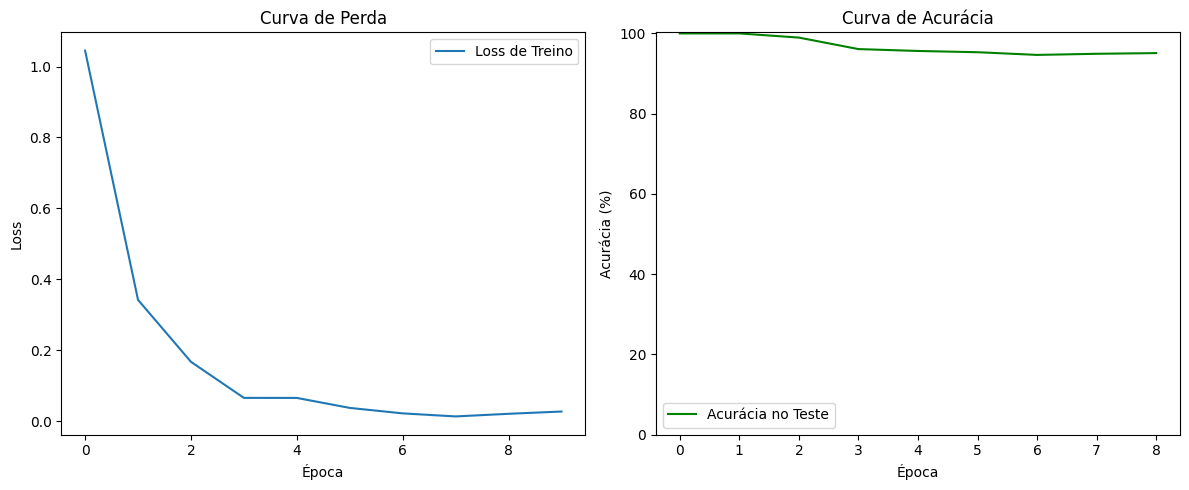

In [14]:
# Plotar curva de perda
plt.figure(figsize=(12, 5))
# plt.title("Evolução da Perda e Acurácia Durante o Treinamento")
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss de Treino')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.title('Curva de Perda')
plt.legend()

# Plotar curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Acurácia no Teste', color='green')
plt.xlabel('Época')
plt.ylabel('Acurácia (%)')
plt.title('Curva de Acurácia')
plt.legend()
plt.ylim(bottom=0)  

plt.tight_layout()
plt.show()

**ResNet avaliação**

=== Classification Report ===
                  precision    recall  f1-score   support

    C. bocourti1       0.97      1.00      0.98        30
       C. danae1       0.84      0.97      0.90        33
C. exasperatus10       0.91      0.77      0.83        13
   C. larvatus01       1.00      1.00      1.00        18
     C. ornatus1       0.96      0.79      0.87        29
     C. sapidus0       0.94      1.00      0.97        16

        accuracy                           0.93       139
       macro avg       0.94      0.92      0.93       139
    weighted avg       0.93      0.93      0.93       139

=== Matriz de Confusão ===


C:\Users\vitin\AppData\Local\Temp\ipykernel_16104\1412345200.py:59: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\vitin\Documents\LABEEC\siri\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


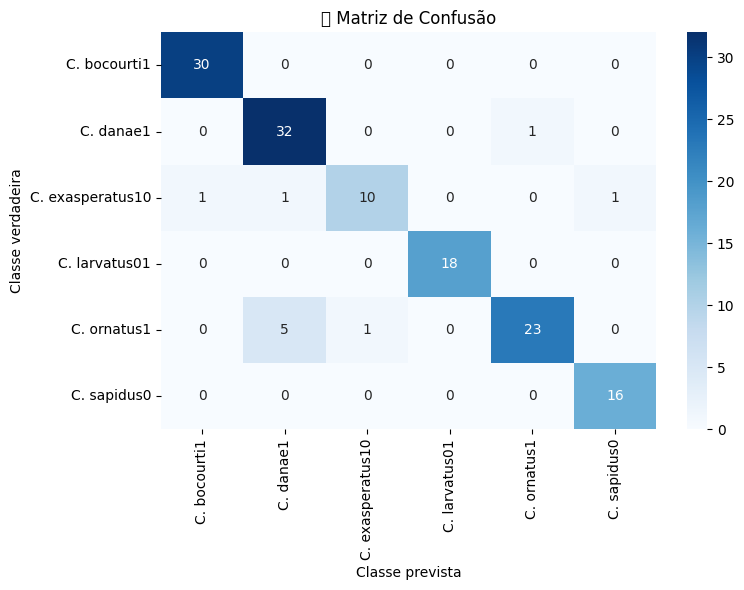

In [ ]:
import torch
import os
from PIL import Image
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# === CONFIGURAÇÕES ===
caminho_dataset = 'siris_dataset_split/external'
classes = sorted(os.listdir(caminho_dataset))  # os nomes das pastas são os nomes das classes
class_to_idx = {classe: idx for idx, classe in enumerate(classes)}
caminho_modelo = './models_gray/modelo_final_res_net.pth'  # Caminho para o modelo treinado

# === TRANSFORMAÇÕES ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === CARREGAR MODELO ===
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, len(classes))
model.load_state_dict(torch.load(caminho_modelo, map_location='cpu'))
model.eval()

# === AVALIAÇÃO ===
y_true = []
y_pred = []

for classe in classes:
    pasta_classe = os.path.join(caminho_dataset, classe)
    for img_nome in os.listdir(pasta_classe):
        if not img_nome.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            continue
        img_path = os.path.join(pasta_classe, img_nome)
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0)

        with torch.no_grad():
            output = model(img_tensor)
            _, pred = torch.max(output, 1)

        y_true.append(class_to_idx[classe])
        y_pred.append(pred.item())

# === RELATÓRIO ===
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=classes))

print("=== Matriz de Confusão ===")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Classe prevista")
plt.ylabel("Classe verdadeira")
plt.title("🔍 Matriz de Confusão")
plt.tight_layout()
plt.show()


**Avalição do Modelo AlexNet**

c:\Users\vitin\Documents\LABEEC\siri\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vitin\Documents\LABEEC\siri\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


=== Classification Report ===
                  precision    recall  f1-score   support

    C. bocourti1       1.00      1.00      1.00        30
       C. danae1       0.77      0.91      0.83        33
C. exasperatus10       1.00      0.62      0.76        13
   C. larvatus01       1.00      1.00      1.00        18
     C. ornatus1       0.82      0.79      0.81        29
     C. sapidus0       0.94      0.94      0.94        16

        accuracy                           0.89       139
       macro avg       0.92      0.88      0.89       139
    weighted avg       0.90      0.89      0.89       139

=== Matriz de Confusão ===


C:\Users\vitin\AppData\Local\Temp\ipykernel_16104\2567391791.py:59: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\vitin\Documents\LABEEC\siri\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


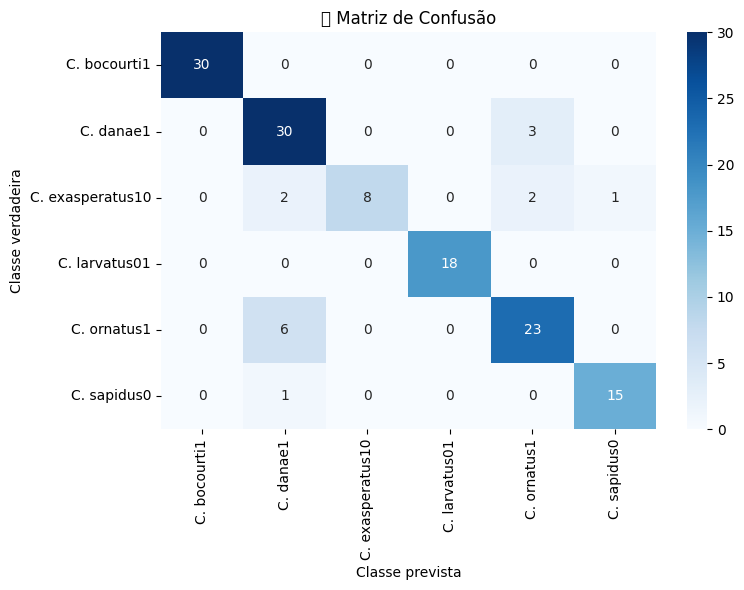

In [ ]:
import torch
import os
from PIL import Image
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# === CONFIGURAÇÕES ===
caminho_dataset = 'siris_dataset_split/external'
classes = sorted(os.listdir(caminho_dataset))  # os nomes das pastas são os nomes das classes
class_to_idx = {classe: idx for idx, classe in enumerate(classes)}
caminho_modelo = './models_gray/modelo_final_alex_net.pth'  # Caminho para o modelo treinado

# === TRANSFORMAÇÕES ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === CARREGAR MODELO ===
model = models.alexnet(pretrained=False)
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, len(classes))
model.load_state_dict(torch.load(caminho_modelo, map_location='cpu'))
model.eval()

# === AVALIAÇÃO ===
y_true = []
y_pred = []

for classe in classes:
    pasta_classe = os.path.join(caminho_dataset, classe)
    for img_nome in os.listdir(pasta_classe):
        if not img_nome.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            continue
        img_path = os.path.join(pasta_classe, img_nome)
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0)

        with torch.no_grad():
            output = model(img_tensor)
            _, pred = torch.max(output, 1)

        y_true.append(class_to_idx[classe])
        y_pred.append(pred.item())

# === RELATÓRIO ===
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=classes))

print("=== Matriz de Confusão ===")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Classe prevista")
plt.ylabel("Classe verdadeira")
plt.title("🔍 Matriz de Confusão")
plt.tight_layout()
plt.show()

**Avaliação do modelo MobileNetV2**

c:\Users\vitin\Documents\LABEEC\siri\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vitin\Documents\LABEEC\siri\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


=== Classification Report ===
                  precision    recall  f1-score   support

    C. bocourti1       0.97      1.00      0.98        30
       C. danae1       0.79      0.94      0.86        33
C. exasperatus10       1.00      0.69      0.82        13
   C. larvatus01       1.00      1.00      1.00        18
     C. ornatus1       0.96      0.83      0.89        29
     C. sapidus0       0.88      0.94      0.91        16

        accuracy                           0.91       139
       macro avg       0.93      0.90      0.91       139
    weighted avg       0.92      0.91      0.91       139

=== Matriz de Confusão ===


C:\Users\vitin\AppData\Local\Temp\ipykernel_16104\1842501701.py:60: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\vitin\Documents\LABEEC\siri\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


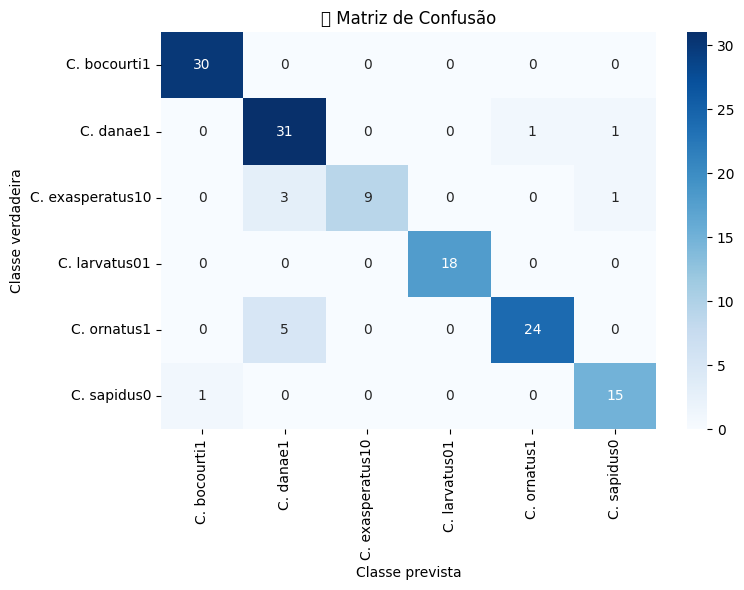

In [ ]:
import torch
import os
from PIL import Image
from torchvision import transforms, models
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# === CONFIGURAÇÕES ===
caminho_dataset = 'siris_dataset_split/external'
classes = sorted(os.listdir(caminho_dataset))  # os nomes das pastas são os nomes das classes
class_to_idx = {classe: idx for idx, classe in enumerate(classes)}
caminho_modelo = './models_gray/modelo_final_mobile_net.pth'  # Caminho para o modelo treinado

# === TRANSFORMAÇÕES ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === CARREGAR MODELO ===
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.last_channel, len(classes))
model.load_state_dict(torch.load(caminho_modelo, map_location='cpu'))
model.eval()


# === AVALIAÇÃO ===
y_true = []
y_pred = []

for classe in classes:
    pasta_classe = os.path.join(caminho_dataset, classe)
    for img_nome in os.listdir(pasta_classe):
        if not img_nome.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            continue
        img_path = os.path.join(pasta_classe, img_nome)
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0)

        with torch.no_grad():
            output = model(img_tensor)
            _, pred = torch.max(output, 1)

        y_true.append(class_to_idx[classe])
        y_pred.append(pred.item())

# === RELATÓRIO ===
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=classes))

print("=== Matriz de Confusão ===")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Classe prevista")
plt.ylabel("Classe verdadeira")
plt.title("🔍 Matriz de Confusão")
plt.tight_layout()
plt.show()

c:\Users\vitin\Documents\LABEEC\siri\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\vitin\Documents\LABEEC\siri\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


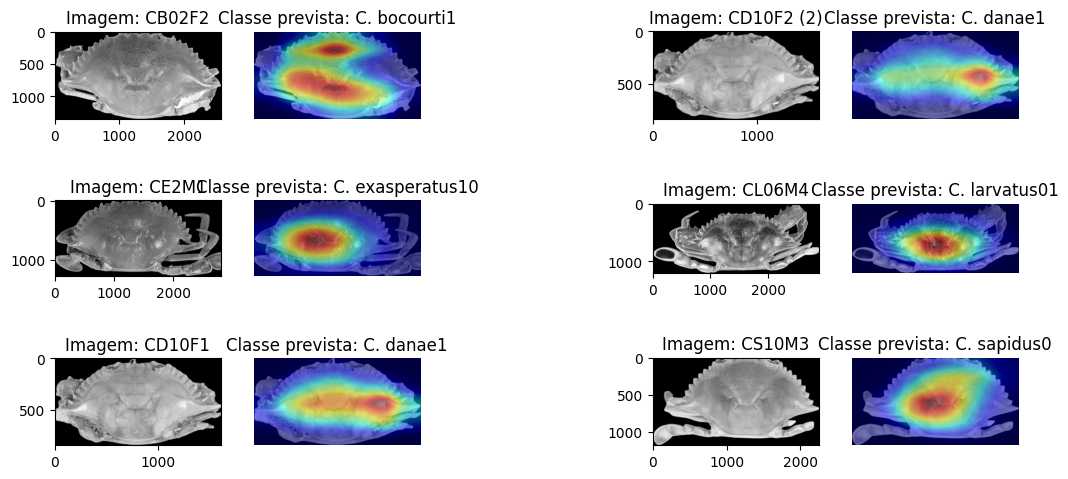

In [ ]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

# === CONFIGURAÇÕES ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_path = "./models_gray/modelo_final_res_net.pth"
caminho_dataset = 'siris_dataset_split/external'
classes = sorted(os.listdir(caminho_dataset))

# === TRANSFORMAÇÕES ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === CARREGAR MODELO ===
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, len(classes))
model.load_state_dict(torch.load(modelo_path, map_location=device))
model.to(device)
model.eval()

plt.figure(figsize=(15, 6))
cont = 0
for idx, classe in enumerate(classes):
    pasta_classe = os.path.join(caminho_dataset, classe)
    img_nome =  os.listdir(pasta_classe)[0]

    if not img_nome.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        continue

    #  === CARREGAR IMAGEM ===
    img_path = os.path.join(pasta_classe, img_nome)
    img = Image.open(img_path).convert('RGB')
    
    img_tensor = transform(img).unsqueeze(0)

    output = model(img_tensor)
    _, pred = torch.max(output, 1)

    # === APLICAR Grad-CAM ===
    cam_extractor = GradCAM(model, target_layer='layer4')

    output = model(img_tensor)
    pred_class = output.argmax().item()

    # Extrair ativação e sobrepor com imagem original
    activation_map = cam_extractor(pred_class, output)[0].cpu()

    # Converter imagem e ativação para PIL
    activation_pil = to_pil_image(activation_map, mode='F')

    # Gerar imagem com sobreposição (mapa de calor)
    result = overlay_mask(img, activation_pil, alpha=0.5)

    # Mostrar com matplotlib
    img_nome = img_nome.split('_')[0]
    cont+=1
    plt.subplot(3,6, idx + cont)
    plt.title(f"Imagem: {img_nome}")
    plt.imshow(img)
    cont+=1
    plt.subplot(3,6, idx + cont)
    plt.axis("off")
    plt.imshow(result)
    plt.title(f"Classe prevista: {classes[pred_class]}")
    plt.axis("off")
plt.show()


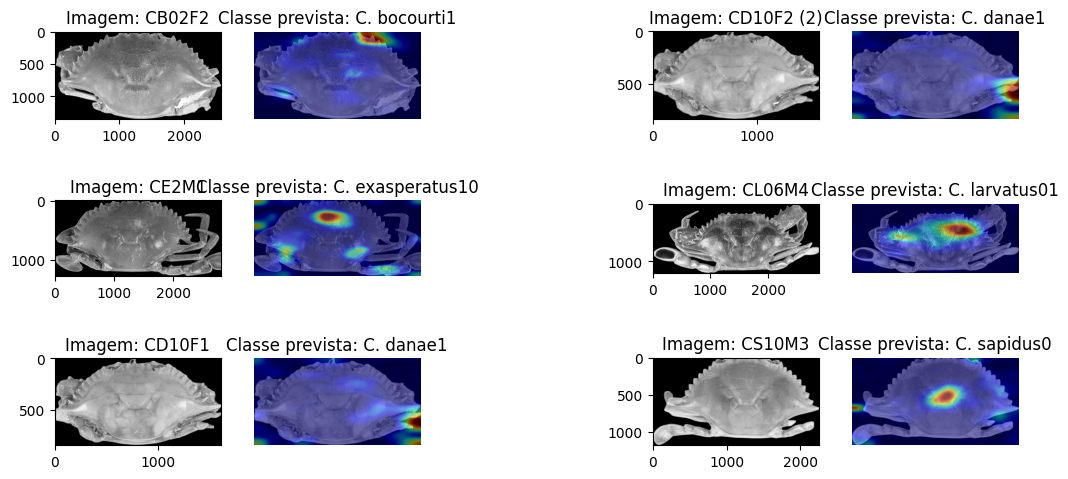

In [ ]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

# === CONFIGURAÇÕES ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_path = "./models_gray/modelo_final_alex_net.pth"
caminho_dataset = 'siris_dataset_split/external'
classes = sorted(os.listdir(caminho_dataset))

# === TRANSFORMAÇÕES ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === CARREGAR MODELO ===
model = models.alexnet(pretrained=False)
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, len(classes))
model.load_state_dict(torch.load(modelo_path, map_location='cpu'))
model.eval()

plt.figure(figsize=(15, 6))
cont = 0
for idx, classe in enumerate(classes):
    pasta_classe = os.path.join(caminho_dataset, classe)
    img_nome =  os.listdir(pasta_classe)[0]

    if not img_nome.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        continue

    #  === CARREGAR IMAGEM ===
    img_path = os.path.join(pasta_classe, img_nome)
    img = Image.open(img_path).convert('RGB')
    
    img_tensor = transform(img).unsqueeze(0)

    output = model(img_tensor)
    _, pred = torch.max(output, 1)

    # === APLICAR Grad-CAM ===
    cam_extractor = GradCAM(model, target_layer='features.11')

    output = model(img_tensor)
    pred_class = output.argmax().item()

    # Extrair ativação e sobrepor com imagem original
    activation_map = cam_extractor(pred_class, output)[0].cpu()

    # Converter imagem e ativação para PIL
    activation_pil = to_pil_image(activation_map, mode='F')

    # Gerar imagem com sobreposição (mapa de calor)
    result = overlay_mask(img, activation_pil, alpha=0.5)

    # Mostrar com matplotlib
    img_nome = img_nome.split('_')[0]
    cont+=1
    plt.subplot(3,6, idx + cont)
    plt.title(f"Imagem: {img_nome}")
    plt.imshow(img)
    cont+=1
    plt.subplot(3,6, idx + cont)
    plt.axis("off")
    plt.imshow(result)
    plt.title(f"Classe prevista: {classes[pred_class]}")
    plt.axis("off")
plt.show()


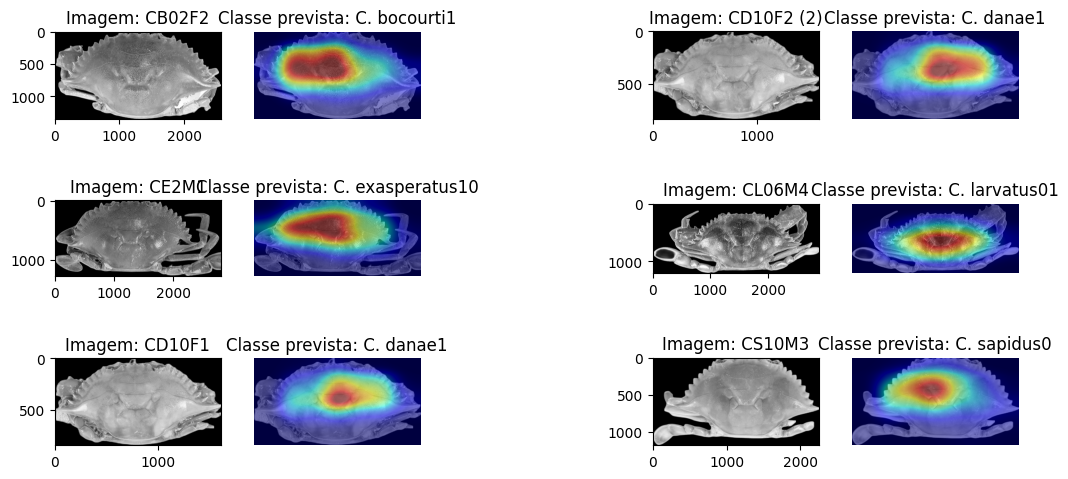

In [ ]:
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

# === CONFIGURAÇÕES ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_path = "./models_gray/modelo_final_mobile_net.pth"
caminho_dataset = 'siris_dataset_split/external'
classes = sorted(os.listdir(caminho_dataset))

# === TRANSFORMAÇÕES ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === CARREGAR MODELO ===
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.last_channel, len(classes))
model.load_state_dict(torch.load(modelo_path, map_location='cpu'))
model.eval()

plt.figure(figsize=(15, 6))
cont = 0
for idx, classe in enumerate(classes):
    pasta_classe = os.path.join(caminho_dataset, classe)
    img_nome =  os.listdir(pasta_classe)[0]

    if not img_nome.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        continue

    #  === CARREGAR IMAGEM ===
    img_path = os.path.join(pasta_classe, img_nome)
    img = Image.open(img_path).convert('RGB')
    
    img_tensor = transform(img).unsqueeze(0)

    output = model(img_tensor)
    _, pred = torch.max(output, 1)

    # === APLICAR Grad-CAM ===
    cam_extractor = GradCAM(model, target_layer='features.18')

    output = model(img_tensor)
    pred_class = output.argmax().item()

    # Extrair ativação e sobrepor com imagem original
    activation_map = cam_extractor(pred_class, output)[0].cpu()

    # Converter imagem e ativação para PIL
    activation_pil = to_pil_image(activation_map, mode='F')

    # Gerar imagem com sobreposição (mapa de calor)
    result = overlay_mask(img, activation_pil, alpha=0.5)

    # Mostrar com matplotlib
    img_nome = img_nome.split('_')[0]
    cont+=1
    plt.subplot(3,6, idx + cont)
    plt.title(f"Imagem: {img_nome}")
    plt.imshow(img)
    cont+=1
    plt.subplot(3,6, idx + cont)
    plt.axis("off")
    plt.imshow(result)
    plt.title(f"Classe prevista: {classes[pred_class]}")
    plt.axis("off")
plt.show()
